# EDA and Preprocessing

Here I'll be performing my initial exploratory analysis to get a feel for the data and see what some of the most common words and bigrams used in each subreddit page are.

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

pd.options.display.max_colwidth = 200

In [2]:
# Reading in the saved CSV file

reddit = pd.read_csv('../datasets/reddit_all_columns_df.csv')
reddit.drop(columns='Unnamed: 0', inplace=True)
print(reddit.shape)
reddit[['subreddit', 'title', 'selftext']].iloc[list(range(5)) + list(range(-5,0))]

(1870, 89)


,subreddit,title,selftext
0,Ohio,About the Donovan Lewis police shooting in Columbus.,Donovan reacted as naturally as anyone would when strangers burst open your bedroom door. There is inherent risk when serving a warrant and going through someone’s home unwelcomed. Cops need to re...
1,Ohio,The chokehold JD Vance has on my YouTube ads.,"No matter how much you tell me about it, I’m not reading Hillbilly Elegy. But seriously, Tim Ryan needs to make an ad on there."
2,Ohio,Need wedding photographer plzzz,Hi everyone my fiancé and I booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . The past 2 weeks we have called then emailed even txted an...
3,Ohio,Ranked choice voting?,"Alaska seems to be doing well, when does Ohio follow."
4,Ohio,How long is the wait for a handgun purchased from Atlantic gun &amp; tackle,Not sure if this is the right place to be asking. But I recently just purchased a handgun from Atlantic gun &amp; tackle and they said I could get approved today in the next hour or it could be up...
1865,IHateOhio,Candle knows what’s up!,NaN
1866,IHateOhio,"Caught this monstrous DiWhy in SE MI, cherry on top was the license plate",NaN
1867,IHateOhio,Cuyahoga named River of the Year,NaN
1868,IHateOhio,Cursed_tribute,NaN
1869,IHateOhio,I hate Ohio,NaN


In [3]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 89 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  1725 non-null   object 
 1   allow_live_comments            1676 non-null   object 
 2   author                         1870 non-null   object 
 3   author_flair_css_class         26 non-null     object 
 4   author_flair_richtext          1851 non-null   object 
 5   author_flair_text              207 non-null    object 
 6   author_flair_type              1851 non-null   object 
 7   author_fullname                1851 non-null   object 
 8   author_is_blocked              790 non-null    object 
 9   author_patreon_flair           1833 non-null   object 
 10  author_premium                 1522 non-null   object 
 11  awarders                       1627 non-null   object 
 12  can_mod_post                   1870 non-null   b

In [4]:
reddit.isnull().sum().sum()

63489

Of the 166,430 cells in the dataframe, 63,489 are null values, which is about 38%. 

Rather than clean each column, I'm going to filter the dataframe to the columns that I think will provide value in analysis and then proceed from there to clean those more important features.

In [5]:
reddit = reddit[['subreddit', 'title', 'selftext', 'author']]

reddit.head()

,subreddit,title,selftext,author
0,Ohio,About the Donovan Lewis police shooting in Columbus.,Donovan reacted as naturally as anyone would when strangers burst open your bedroom door. There is inherent risk when serving a warrant and going through someone’s home unwelcomed. Cops need to re...,barelycriminal
1,Ohio,The chokehold JD Vance has on my YouTube ads.,"No matter how much you tell me about it, I’m not reading Hillbilly Elegy. But seriously, Tim Ryan needs to make an ad on there.",DreamsAndBoxes
2,Ohio,Need wedding photographer plzzz,Hi everyone my fiancé and I booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . The past 2 weeks we have called then emailed even txted an...,Ohiowelder
3,Ohio,Ranked choice voting?,"Alaska seems to be doing well, when does Ohio follow.",titanup1993
4,Ohio,How long is the wait for a handgun purchased from Atlantic gun &amp; tackle,Not sure if this is the right place to be asking. But I recently just purchased a handgun from Atlantic gun &amp; tackle and they said I could get approved today in the next hour or it could be up...,Professional_Pie4546


In [6]:
reddit.isnull().sum()

subreddit      0
title          0
selftext     788
author         0
dtype: int64

We can see here that a lot of the 'selftext' values are null. When I was looking into the two subreddit pages, I noticed that a lot of times a majority of the post would be in the title itself. 

Even with the parameter added for selftext when scraping the threads, we see a similar pattern of empty captions. I'm hoping that this may in fact help the model, because all null selftext values are from the IHateOhio subreddit, which may be an indicator of which thread the post is from.

I'm going to do some light EDA to see if there are any patterns in title and/or post length among the two subreddits.

In [7]:
reddit['title_word_count'] = [len(i.split()) for i in reddit['title']]
reddit['selftext_word_count'] = [len(str(i).split()) for i in reddit['selftext']]

In [8]:
reddit.groupby('subreddit')['title_word_count'].mean()

subreddit
IHateOhio    8.103753
Ohio         9.095436
Name: title_word_count, dtype: float64

In [9]:
reddit.groupby('subreddit')['selftext_word_count'].mean()

subreddit
IHateOhio    11.724062
Ohio         68.804979
Name: selftext_word_count, dtype: float64

While the mean title lengths are somewhat similar, it looks like users in the Ohio subreddit are wordier in the captions than those posting in the IHateOhio subreddit.

In [10]:
print(f"Mean number of posts per user: {reddit.groupby('author')['title'].count().mean()}")
reddit.groupby('author')['title'].count().sort_values(ascending=False)

Mean number of posts per user: 1.3689604685212298


author
RandomGuy952      46
Ow_wow            27
GriffinFTW        25
[deleted]         19
Vonandro          18
                  ..
Oijias             1
Ohiowelder         1
Ohiobo6294         1
OffToTheLizard     1
zvbgamer           1
Name: title, Length: 1366, dtype: int64

We can see here that the average number of posts per user is just over 1, but some users post more frequently than others.

In [11]:
reddit.describe()

,title_word_count,selftext_word_count
count,1870.000000,1870.000000
mean,8.614973,41.149733
std,7.446789,96.700965
min,1.000000,1.000000
25%,4.000000,1.000000
50%,6.000000,7.000000
75%,11.000000,50.000000
max,59.000000,2372.000000


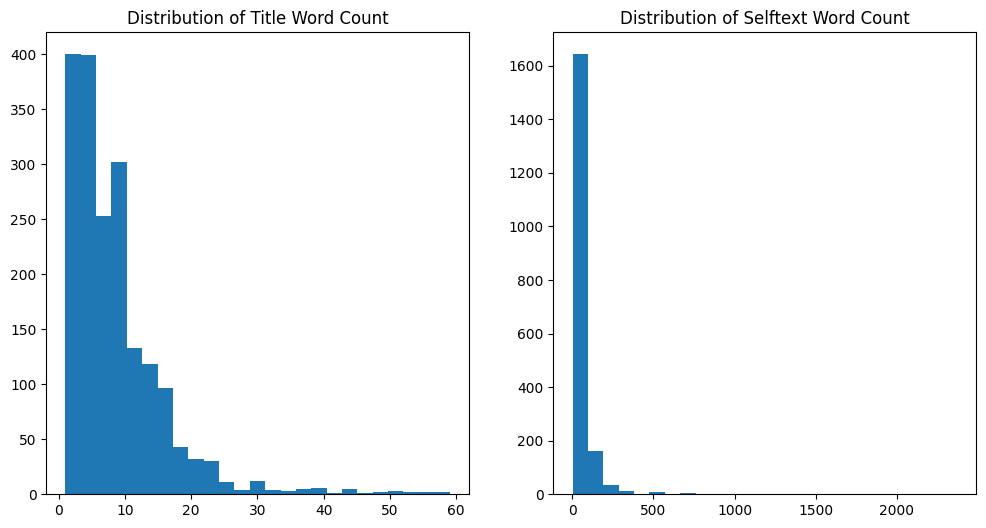

In [12]:
plt.figure(figsize=(12, 6))

cols = ['title_word_count', 'selftext_word_count']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.hist(reddit[cols[i]], bins=25)
    split_words = cols[i].split('_')
    split_words = [i.title() for i in split_words]
    joined_words = ' '.join(split_words)
    plt.title(f'Distribution of {joined_words}')

Despite the 700+ null cells, the selftext_word_count column has a greater mean and max value than the title_word_count column. 

We can also see from the histograms that the distributions for both (combined subreddit) measures is highly skewed. Specifically, the selftext distribution looks to contain most counts between 0 and 250 words, but the maximum of 2,372 words (an outlier) is affecting the distribution.

In [13]:
reddit.corr()

,title_word_count,selftext_word_count
title_word_count,1.00000,0.01967
selftext_word_count,0.01967,1.00000


There is very weak correlation between title word count and caption word count. This is likely partially due to the many null values in the selftext column, but could also imply that those who write long titles do not necessarily write long captions, as well.

In [14]:
# Now dealing with the nulls

reddit.isnull().sum()

subreddit                0
title                    0
selftext               788
author                   0
title_word_count         0
selftext_word_count      0
dtype: int64

In [15]:
# Now dealing with the nulls
print(f'Total nulls before imputation: {reddit.isnull().sum().sum()}')

reddit.fillna(' ', inplace=True)

# Checking that the changes were made
reddit.isnull().sum()

Total nulls before imputation: 788


subreddit              0
title                  0
selftext               0
author                 0
title_word_count       0
selftext_word_count    0
dtype: int64

In [16]:
'''I'm also going to lowercase all words within the object-type columns before employing CountVectorizer
I know that all context is lowercased by default when using CV
But the values that are checked against the stopwords are not always lowercased, meaning that some stopwords will be missed,
depending on their case in the original post/df
Source: https://github.com/scikit-learn/scikit-learn/issues/19311'''

reddit = reddit.applymap(lambda x: x.lower() if type(x) == str else x)
reddit.rename(columns={'subreddit': 'subreddit_class'}, inplace=True) # Doing this before vectorizing in case the word 'subreddit' is used at all
reddit.to_csv('../datasets/reddit_slimmed.csv')

reddit.head(3)

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
0,ohio,about the donovan lewis police shooting in columbus.,donovan reacted as naturally as anyone would when strangers burst open your bedroom door. there is inherent risk when serving a warrant and going through someone’s home unwelcomed. cops need to re...,barelycriminal,8,48
1,ohio,the chokehold jd vance has on my youtube ads.,"no matter how much you tell me about it, i’m not reading hillbilly elegy. but seriously, tim ryan needs to make an ad on there.",dreamsandboxes,9,25
2,ohio,need wedding photographer plzzz,hi everyone my fiancé and i booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . the past 2 weeks we have called then emailed even txted an...,ohiowelder,4,77


---
## EDA on Title and SelfText Columns

In [17]:
cvec = CountVectorizer(stop_words='english')

reddit_fit = cvec.fit_transform(reddit['title'])

In [18]:
reddit_fit.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [19]:
title_df = pd.DataFrame(reddit_fit.todense(), columns=cvec.get_feature_names_out())

title_df.head()

,00,000,00am,04,05,0h10,10,100,10000,1099,...,yugi,yup,zanesville,zero,zimbabwe,zipline,zito,zmepugcad,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### What are the 20 most common words used in titles for both subreddits?

In [20]:
top_20_all = title_df.sum(axis=0).sort_values(ascending=False).head(20)

top_20_all

ohio            807
state            93
hate             71
just             51
like             51
fuck             51
people           50
unemployment     48
new              37
place            35
columbus         35
looking          34
oh               32
live             32
help             31
need             30
know             30
best             29
time             29
got              28
dtype: int64

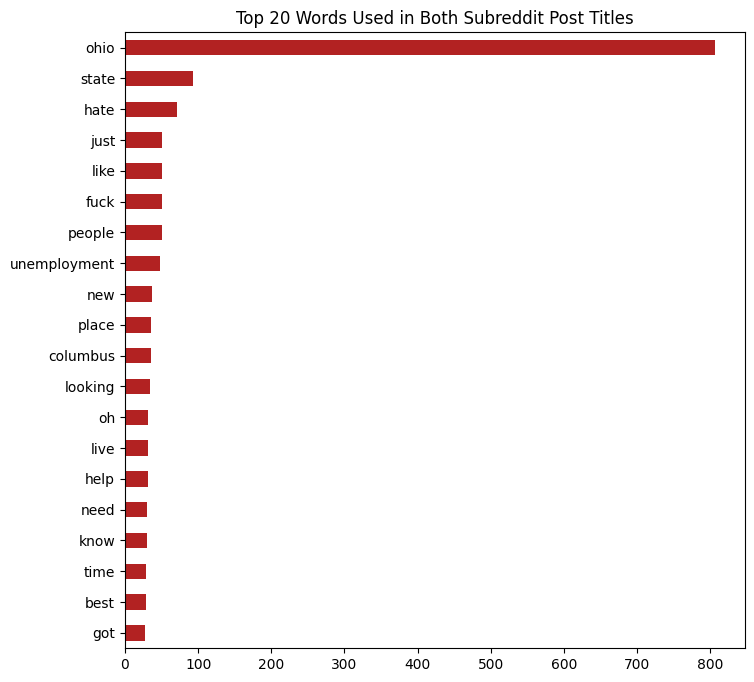

In [21]:
plt.figure(figsize=(8,8))
top_20_all.sort_values(ascending=True).plot.barh(title='Top 20 Words Used in Both Subreddit Post Titles', color='firebrick');

In [22]:
words_and_counts = pd.concat([title_df, reddit], axis=1)
words_and_counts.head(3)

,00,000,00am,04,05,0h10,10,100,10000,1099,...,zito,zmepugcad,zone,zoom,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,ohio,about the donovan lewis police shooting in columbus.,donovan reacted as naturally as anyone would when strangers burst open your bedroom door. there is inherent risk when serving a warrant and going through someone’s home unwelcomed. cops need to re...,barelycriminal,8,48
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,ohio,the chokehold jd vance has on my youtube ads.,"no matter how much you tell me about it, i’m not reading hillbilly elegy. but seriously, tim ryan needs to make an ad on there.",dreamsandboxes,9,25
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,ohio,need wedding photographer plzzz,hi everyone my fiancé and i booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . the past 2 weeks we have called then emailed even txted an...,ohiowelder,4,77


### How about in selftext?

In [23]:
cvec = CountVectorizer(stop_words='english')

# I'm starting with the title column to vectorize because many of the selftext column is empty strings
reddit_st_fit = cvec.fit_transform(reddit['selftext'])

In [24]:
selftext_df = pd.DataFrame(reddit_st_fit.todense(), columns=cvec.get_feature_names_out())

top_20_st = selftext_df.sum(axis=0).sort_values(ascending=False).head(20)

top_20_st

ohio       743
https      400
just       392
amp        306
com        281
state      272
like       272
people     255
know       253
www        192
ve         160
don        157
want       155
time       147
looking    122
help       120
need       113
place      107
good       104
going      101
dtype: int64

In [25]:
selftext_df.filter(regex='https').sum()

https    400
dtype: int64

Unlike the title, it looks like there are quite few links in the selftext sections of posts. I'm going to filter a few of these out get a better sense of what actual words are most present in post captions.

In [26]:
drop_list = ['https', 'amp', 'com', 'www', 'don', 've', 'x200b', 'png']
cols_keep = [col for col in selftext_df.columns if col not in drop_list]
selftext_df = selftext_df[cols_keep]

In [27]:
top_20_st = selftext_df.sum(axis=0).sort_values(ascending=False).head(20)

top_20_st

ohio       743
just       392
like       272
state      272
people     255
know       253
want       155
time       147
looking    122
help       120
need       113
place      107
good       104
going      101
new         99
live        98
make        96
year        93
really      91
think       88
dtype: int64

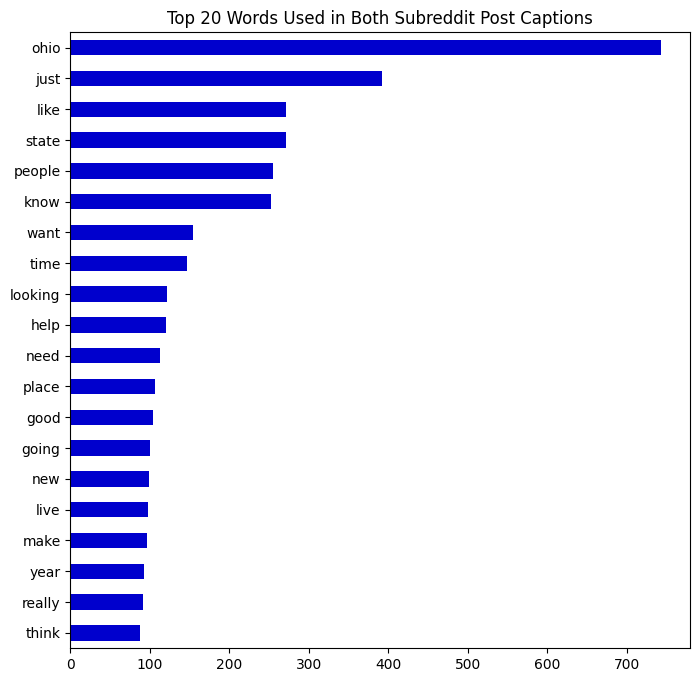

In [28]:
plt.figure(figsize=(8,8))
top_20_st.sort_values(ascending=True).plot.barh(title='Top 20 Words Used in Both Subreddit Post Captions', color='mediumblue');

### Did any users post in both subreddit threads?

In [29]:
reddit_auth_cleaned = reddit[reddit['author'] != '[deleted]']

reddit_auth_cleaned[reddit_auth_cleaned.groupby('author')['subreddit_class'].transform('nunique')>1]

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
908,ohio,i hate ohio?,i just don’t like ohio you know i just hate it bad weather stupid place ahhhh. i mean let’s just firebomb cleveland or cincinnati or just the whole state i just don’t like it stupid place. i’m sha...,kipdu,3,44
1128,ihateohio,3000 members,cool little thing guys congrats!,kipdu,2,5
1183,ihateohio,oh thank god there’s a subreddit for this i just hate ohio so much it’s terrible i’m litterly shaking let’s firebomb cleveland and cincinnati,,kipdu,24,1
1189,ihateohio,oh my gosh i’m so grateful that i’m now a moderator for my favorite subreddit.,,kipdu,15,1
1199,ihateohio,obviously its ohio,[https://www.nbcnews.com/news/us-news/frantic-parents-fear-kids-after-radioactive-contamination-found-ohio-middle-n1005771](https://www.nbcnews.com/news/us-news/frantic-parents-fear-kids-after-ra...,kipdu,3,1
1466,ihateohio,the man...,,kipdu,2,1
1647,ihateohio,can’t wait for ohio to be gone 😊,,kipdu,8,1


One user posted in both the Ohio and IHateOhio subreddits, but appears to have a strong dislike of the state in all posts.

### What were the top 10 words used separately in each subreddit title?

In [30]:
ohio_top_10 = words_and_counts[words_and_counts['subreddit_class'] == 'ohio'].iloc[:, :-6].sum(axis=0).sort_values(ascending=False).head(10)
hate_ohio_top_10 = words_and_counts[words_and_counts['subreddit_class'] == 'ihateohio'].iloc[:, :-6].sum(axis=0).sort_values(ascending=False).head(10)

In [31]:
top_10_each = pd.concat([ohio_top_10, hate_ohio_top_10])
top_10_each = top_10_each.reset_index().rename(columns={'index': 'word', 0: 'count'})
top_10_each

,word,count
0,ohio,306
1,unemployment,46
2,state,41
3,looking,34
4,columbus,27
5,need,25
6,people,25
7,know,25
8,help,24
9,question,23


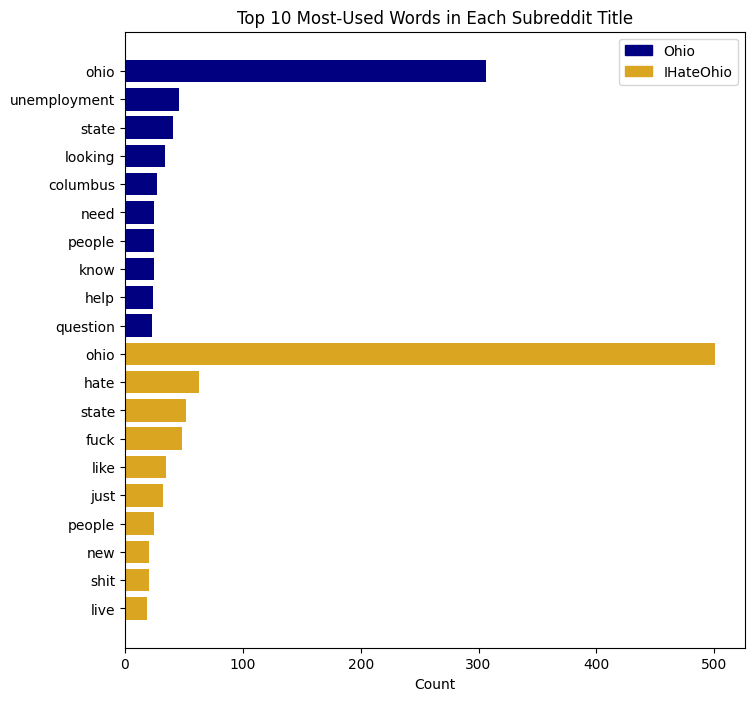

In [32]:
colors = ['navy', 'navy', 'navy', 'navy', 'navy', 'navy', 'navy', 'navy', 'navy', 'navy', 'goldenrod', 'goldenrod', 'goldenrod', 'goldenrod', 'goldenrod', 'goldenrod', 'goldenrod', 'goldenrod', 'goldenrod', 'goldenrod']

plt.figure(figsize=(8,8))
plt.barh(y=top_10_each.index[::-1], width=top_10_each['count'], color = colors)
plt.yticks(ticks = top_10_each.index, labels=top_10_each['word'][::-1])
ohio = mpatches.Patch(color='navy', label='Ohio')
hateohio = mpatches.Patch(color='goldenrod', label='IHateOhio')
plt.legend(handles=[ohio, hateohio])
plt.xlabel('Count')
plt.title('Top 10 Most-Used Words in Each Subreddit Title');

### Now looking at selftext.

In [33]:
st_words_and_counts = pd.concat([selftext_df, reddit], axis=1)
st_ohio_top_10 = st_words_and_counts[st_words_and_counts['subreddit_class'] == 'ohio'].iloc[:, :-6].sum(axis=0).sort_values(ascending=False).head(10)
st_hate_ohio_top_10 = st_words_and_counts[st_words_and_counts['subreddit_class'] == 'ihateohio'].iloc[:, :-6].sum(axis=0).sort_values(ascending=False).head(10)

In [34]:
st_top_10_each = pd.concat([st_ohio_top_10, st_hate_ohio_top_10])
st_top_10_each = st_top_10_each.reset_index().rename(columns={'index': 'word', 0: 'count'})
st_top_10_each

,word,count
0,ohio,495
1,just,312
2,know,230
3,like,220
4,state,203
5,people,197
6,time,136
7,want,129
8,looking,120
9,help,116


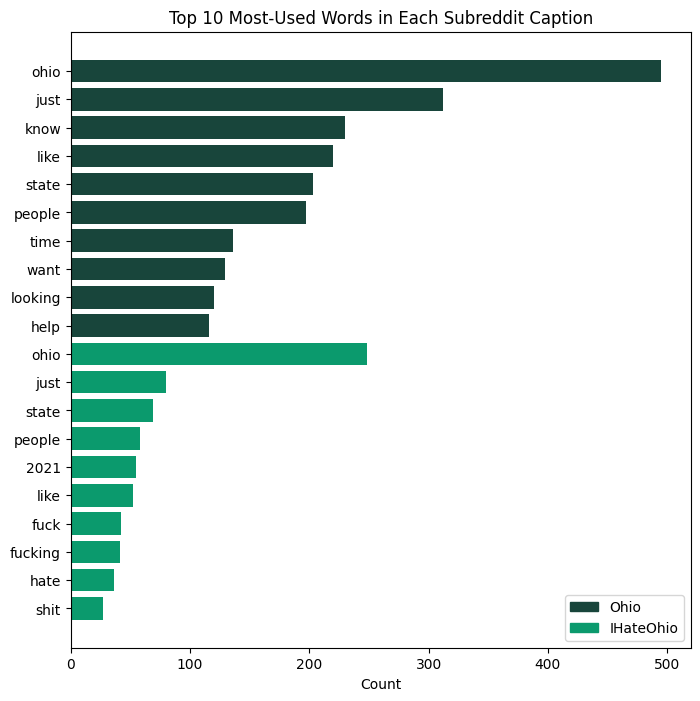

In [35]:
colors = ['#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D']

plt.figure(figsize=(8,8))
plt.barh(y=st_top_10_each.index[::-1], width=st_top_10_each['count'], color = colors)
plt.yticks(ticks = st_top_10_each.index, labels=st_top_10_each['word'][::-1])
ohio = mpatches.Patch(color='#18453B', label='Ohio')
hateohio = mpatches.Patch(color='#0B9A6D', label='IHateOhio')
plt.legend(handles=[ohio, hateohio])
plt.xlabel('Count')
plt.title('Top 10 Most-Used Words in Each Subreddit Caption');

Similar to the title words, there is a clear difference in those shown in the above bar chart. The IHateOhio subreddit has a number of expletives, while the Ohio captions look to be more centered around questions and information.

### What are the most common bigrams in the post titles?

In [36]:
cvec = CountVectorizer(stop_words='english', ngram_range=(2,2))

reddit_bi_fit = cvec.fit_transform(reddit['title'])

reddit_bi_fit.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [37]:
bigram_df = pd.DataFrame(reddit_bi_fit.todense(), columns=cvec.get_feature_names_out())

top_10_bigrams = bigram_df.sum(axis=0).sort_values(ascending=False).head(10)

top_10_bigrams

hate ohio      38
fuck ohio      24
ohio state     15
ohio sucks     15
live ohio      13
ohio like      13
year old       11
hates ohio     10
cedar point     9
ohio man        8
dtype: int64

Because 'ohio' is used in 8 out of 10 of these bigrams, I think it would be more effective to use single words in modeling. 

### What is the overall sentiment of the titles in each subreddit?

In [38]:
sent = SentimentIntensityAnalyzer()

In [39]:
titles = reddit[['title', 'subreddit_class']]

love_sent = []
hate_sent = []

for i in range(len(titles)):
    if titles['subreddit_class'][i] == 'ohio':
        love_sent.append(sent.polarity_scores(titles['title'][i]))
    else:
        hate_sent.append(sent.polarity_scores(titles['title'][i]))            

In [40]:
love_sent_df = pd.DataFrame.from_dict(love_sent)
hate_sent_df = pd.DataFrame.from_dict(hate_sent)

In [41]:
love_sent_df.describe()

,neg,neu,pos,compound
count,964.000000,964.000000,964.000000,964.000000
mean,0.070617,0.844371,0.085012,0.033731
std,0.162051,0.215521,0.161742,0.318067
min,0.000000,0.000000,0.000000,-0.940300
25%,0.000000,0.714000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.141250,0.000000
max,1.000000,1.000000,1.000000,0.955700


In [42]:
hate_sent_df.describe()

,neg,neu,pos,compound
count,906.000000,906.000000,906.000000,906.000000
mean,0.165881,0.737008,0.097116,-0.098194
std,0.234652,0.261642,0.183419,0.392195
min,0.000000,0.000000,0.000000,-0.977500
25%,0.000000,0.555000,0.000000,-0.471175
50%,0.000000,0.757000,0.000000,0.000000
75%,0.306000,1.000000,0.144000,0.000000
max,1.000000,1.000000,1.000000,0.938200


### What is the overall sentiment of the captions in each subreddit?

In [43]:
sent = SentimentIntensityAnalyzer()

In [44]:
selftexts = reddit[['selftext', 'subreddit_class']]

st_love_sent = []
st_hate_sent = []

for i in range(len(selftexts)):
    if selftexts['subreddit_class'][i] == 'ohio':
        st_love_sent.append(sent.polarity_scores(selftexts['selftext'][i]))
    else:
        st_hate_sent.append(sent.polarity_scores(selftexts['selftext'][i]))     

In [45]:
st_love_sent_df = pd.DataFrame.from_dict(st_love_sent)
st_hate_sent_df = pd.DataFrame.from_dict(st_hate_sent)

In [46]:
st_love_sent_df.describe()

,neg,neu,pos,compound
count,964.000000,964.000000,964.000000,964.000000
mean,0.042908,0.737140,0.092353,0.237245
std,0.067907,0.301249,0.102190,0.544487
min,0.000000,0.000000,0.000000,-0.995100
25%,0.000000,0.730750,0.000000,0.000000
50%,0.000000,0.837000,0.074000,0.064150
75%,0.069000,0.906000,0.148000,0.765000
max,0.545000,1.000000,1.000000,0.999600


In [47]:
st_hate_sent_df.describe()

,neg,neu,pos,compound
count,906.000000,906.000000,906.000000,906.000000
mean,0.047866,0.194704,0.023442,-0.056484
std,0.133409,0.343578,0.083016,0.278138
min,0.000000,0.000000,0.000000,-0.997200
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.335750,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.996800


Looking at the means for each dataframe, most posts have a high neutrality score and some variance in all columns. The IHateOhio captions surprisingly had the greatest mean neutrality, but also the lowest mean positivity scores. 

For the sake of analysis and predictions, I'll be using the compound means for each dataframe, as these are described to be the 'normalized, composite score' for each post in [this](https://github.com/cjhutto/vaderSentiment) documentation.

The IHateOhio post titles have the lowest mean compound score, at almost -0.10. On the contrary, the Ohio titles have a relatively impartial score of 0.03. The IHateOhio selftexts have a less impressive mean compound score of -0.06, but the Ohio selftexts have a strong mean of 0.24. 

I'll be interested to see if the heavier negative score in the IHateOhio titles make for better predictions, or if the positive skew of the Ohio selftexts will be more effective in modeling.

In [48]:
hate_des = st_hate_sent_df.describe()
hate_des.loc['mean']

neg         0.047866
neu         0.194704
pos         0.023442
compound   -0.056484
Name: mean, dtype: float64

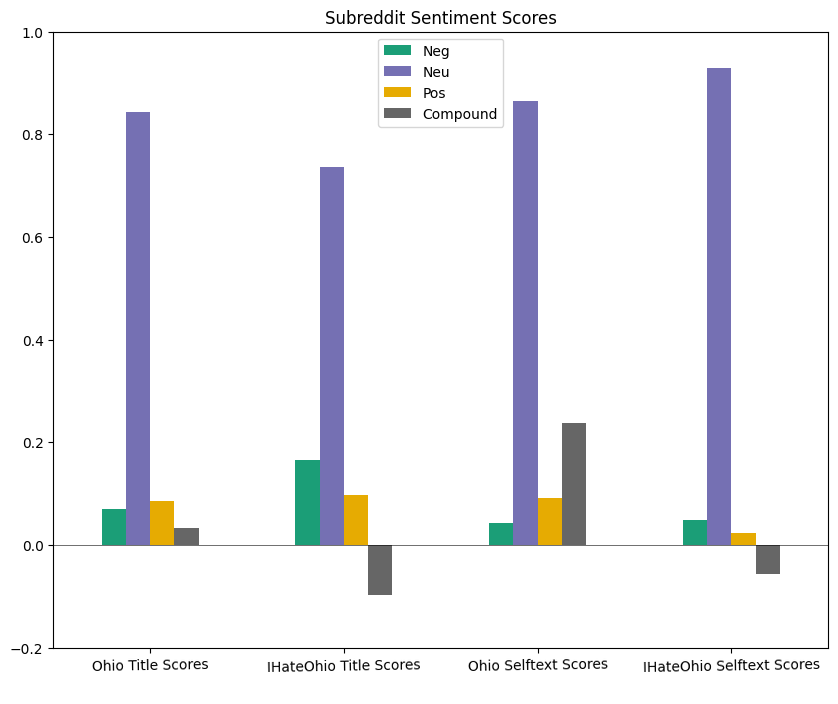

In [49]:
data = [['Ohio Title Scores', 0.070617, 0.844371, 0.085012, 0.033731], ['IHateOhio Title Scores', 0.165881, 0.737008, 0.097116, -0.098194], 
['Ohio Selftext Scores', 0.042908, 0.864733, 0.092353, 0.237245], ['IHateOhio Selftext Scores', 0.047866, 0.928700, 0.023442, -0.056484]]

df = pd.DataFrame(data, columns=['Subreddit', 'Neg', 'Neu', 'Pos', 'Compound'])
df.set_index('Subreddit', inplace=True)

y_tix = [-.2, 0, .2, .4, .6, .8, 1]
df.plot(kind='bar', rot=1, figsize=(10,8), ylim=[-.2, 1], xlabel=' ', colormap='Dark2', title='Subreddit Sentiment Scores', yticks=y_tix)
plt.axhline(y=0, color = 'black', linewidth=0.4)
plt.legend(loc='upper center');

---

## Model Predictions

Going into the model building, I predict the title column to perform better and produce greater test scores than the selftext column. This is because:
- There are no nulls in the title column, but 788 in the selftext column.
- In the graphs above, the most commonly used words are similar among the title and selftext columns. Because there is some resemblance between the two, but less missing data in the title column, I would expect it to be more useful.
- Additionally, I believe the -0.1 mean compound score of the IHateOhio titles will be important in predictions.

With regard to the two subreddit threads, I imagine that the Ohio posts will be somewhat more difficult for most models to classify because there are less strongly-worded phrases.